In [1]:
import numpy as np
import xarray as xr
import os.path as op
from xgcm.grid import Grid as xgrid
from xmitgcm import open_mdsdataset
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
ddir = '/tank/chaocean/'

In [3]:
###############
# Parameters used in the simulation
###############
grav = 9.807
Kh = 20.  # harmonic diffusivity
K4 = 1e10 # biharmonic diff.
Kr = 1e-5 # vertical diff.
xchunk = 500

# Read files to close the temperature budget

In [22]:
dsdiag = open_mdsdataset(op.join(ddir,'qjamet/RUNS/ORAR/memb%02d/run1963/ocn/' % 24), 
                        grid_dir = op.join(ddir,'grid_chaO/gridMIT_update1/'),
                        prefix = ['diag_Tbgt2D','diag_Tbgt3D'], delta_t = 2e2,
                        iters = 943920
                        ).chunk({'XC':xchunk,'XG':xchunk})
dsdiag

<xarray.Dataset>
Dimensions:   (time: 1, XC: 1000, YC: 900, XG: 1000, YG: 900, Z: 46, Zp1: 47,
               Zu: 46, Zl: 46)
Coordinates: (12/33)
    iter      (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * time      (time) timedelta64[ns] 2185 days
  * XC        (XC) >f4 262.0 262.1 262.2 262.3 262.3 ... 347.7 347.8 347.9 348.0
  * YC        (YC) >f4 -19.92 -19.83 -19.75 -19.67 ... 54.75 54.83 54.92 55.0
  * XG        (XG) >f4 262.0 262.0 262.1 262.2 262.3 ... 347.7 347.8 347.8 347.9
  * YG        (YG) >f4 -19.96 -19.87 -19.79 -19.71 ... 54.71 54.79 54.88 54.96
    ...        ...
    maskW     (Z, YC, XG) bool dask.array<chunksize=(46, 900, 500), meta=np.ndarray>
    maskS     (Z, YG, XC) bool dask.array<chunksize=(46, 900, 500), meta=np.ndarray>
    maskInC   (YC, XC) bool dask.array<chunksize=(900, 500), meta=np.ndarray>
    rhoRef    (Z) >f4 dask.array<chunksize=(46,), meta=np.ndarray>
    maskInW   (YC, XG) bool dask.array<chunksize=(900, 500), meta=np.ndarray>
    maskInS   (YG, XC) bool dask.array<chunksize=(900, 500), meta=np.ndarray>
Data variables:
    TFLUX     (time, YC, XC) >f4 dask.array<chunksize=(1, 900, 500), meta=np.ndarray>
    oceQsw    (time, YC, XC) >f4 dask.array<chunksize=(1, 900, 500), meta=np.ndarray>
    WTHMASS   (time, YC, XC) >f4 dask.array<chunksize=(1, 900, 500), meta=np.ndarray>
    TOTTTEND  (time, Z, YC, XC) >f4 dask.array<chunksize=(1, 46, 900, 500), meta=np.ndarray>
    ADVr_TH   (time, Zl, YC, XC) >f4 dask.array<chunksize=(1, 46, 900, 500), meta=np.ndarray>
    ADVx_TH   (time, Z, YC, XG) >f4 dask.array<chunksize=(1, 46, 900, 500), meta=np.ndarray>
    ADVy_TH   (time, Z, YG, XC) >f4 dask.array<chunksize=(1, 46, 900, 500), meta=np.ndarray>
    Diss_TH   (time, Z, YC, XC) >f4 dask.array<chunksize=(1, 46, 900, 500), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    title:        netCDF wrapper of MITgcm MDS binary data
    source:       MITgcm
    history:      Created by calling `open_mdsdataset(grid_dir='/tank/chaocea...

# Let's try taking the divergence of temperature advective flux

In [19]:
grid = xgrid(dsdiag, 
             periodic=['X']  # The North Atlantic domain is configured to wrap around zonally
            )
grid

<xgcm.Grid>
T Axis (not periodic, boundary=None):
  * center   time
X Axis (periodic, boundary=None):
  * center   XC --> left
  * left     XG --> center
Y Axis (not periodic, boundary=None):
  * center   YC --> left
  * left     YG --> center
Z Axis (not periodic, boundary=None):
  * center   Z --> left
  * outer    Zp1 --> center
  * right    Zu --> center
  * left     Zl --> center

In [20]:
Vol_r = dsdiag.rA**-1 * dsdiag.drF**-1 * dsdiag.hFacC**-1

divT = ( grid.diff(dsdiag.ADVx_TH,'X')
         + grid.diff(dsdiag.ADVy_TH,'Y',boundary='extend')
         - grid.diff(dsdiag.ADVr_TH,'Z',boundary='extend')
       ) * Vol_r
divT

<xarray.DataArray (time: 1, Z: 46, YC: 900, XC: 1000)>
dask.array<mul, shape=(1, 46, 900, 1000), dtype=float32, chunksize=(1, 46, 900, 500), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) timedelta64[ns] 2185 days
  * XC       (XC) >f4 262.0 262.1 262.2 262.3 262.3 ... 347.7 347.8 347.9 348.0
  * YC       (YC) >f4 -19.92 -19.83 -19.75 -19.67 ... 54.75 54.83 54.92 55.0
  * Z        (Z) >f4 -3.047 -9.454 -16.36 ... -5.375e+03 -5.625e+03 -5.875e+03
    rA       (YC, XC) >f4 dask.array<chunksize=(900, 500), meta=np.ndarray>
    Depth    (YC, XC) >f4 dask.array<chunksize=(900, 500), meta=np.ndarray>
    maskInC  (YC, XC) bool dask.array<chunksize=(900, 500), meta=np.ndarray>
    drF      (Z) >f4 dask.array<chunksize=(46,), meta=np.ndarray>
    PHrefC   (Z) >f4 dask.array<chunksize=(46,), meta=np.ndarray>
    rhoRef   (Z) >f4 dask.array<chunksize=(46,), meta=np.ndarray>
    hFacC    (Z, YC, XC) >f4 dask.array<chunksize=(46, 900, 500), meta=np.ndarray>
    maskC    (Z, YC, XC) bool dask.array<chunksize=(46, 900, 500), meta=np.ndarray>

/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in reciprocal
  return func(*(_execute_task(a, cache) for a in args))
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))


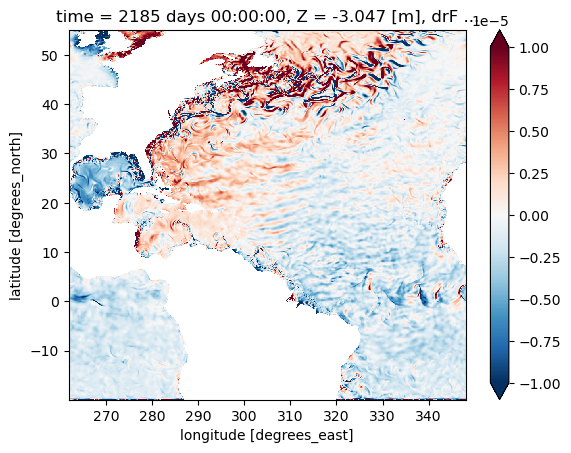

In [21]:
divT.where(dsdiag.maskC!=0.).isel(time=0, Z=0).plot(vmax=1e-5)